In [83]:
# Standard import(s)
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import csv

In [31]:
# Keras import(s)
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Input, Dense, Dropout, Flatten, Reshape, Conv2D, Conv2DTranspose, Concatenate, Lambda,BatchNormalization, MaxPooling2D, UpSampling2D
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.losses import binary_crossentropy
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
from tensorflow.python.keras.backend import set_image_data_format
from tensorflow.keras.optimizers import Adam
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
set_image_data_format('channels_last')  # Images are formatted as (N, N, 1), with colour-channels last

In [32]:
def load_dataset():
    #
    file_index = 1
    data = pd.read_csv("YLR012Calpha0.75179beta9.659tdiff9.0.csv", header=None)
    data['y'] = [file_index] * data.shape[0]
    
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]
    
    file_index += 1
    
    return X, y, file_index    

In [33]:
X, y, file_index = load_dataset()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
print(X_train.shape)

(10000, 99)


In [78]:
data_rho_phys = np.mean(np.mean(X, axis=1))
data_rho_phys

0.04760505050504799

In [34]:
def sampling (args):

  # Unpack arguments
  z_mean, z_log_var = args

  # Get shape of random noise to sample
  epsilon = K.random_normal(shape=K.shape(z_mean))

  # Return samples from latent space p.d.f.
  return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [35]:
original_dim = 99
intermediate_dim = 75
intermediate_dim2 = 50
intermediate_dim3 = 25
latent_dim = 1

In [36]:
inputs = Input(original_dim, name='input')

x = Dense(intermediate_dim, activation='relu')(inputs)

# Means and log(variances) layers both connected to previous dense layer
z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)
# Lambda layer to sample z vector from distribution given by learned means and log(variances) using 'reparameterization trick'
z = Lambda(sampling, output_shape=(latent_dim, ), name='z')([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

In [37]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 99)]         0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 75)           7500        input[0][0]                      
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 1)            76          dense_3[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 1)            76          dense_3[0][0]                    
____________________________________________________________________________________________

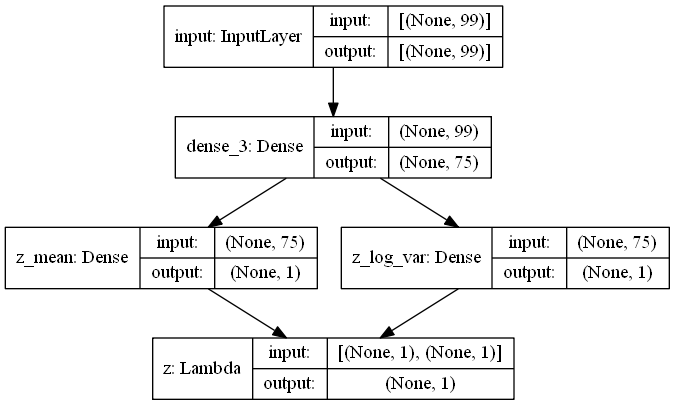

In [38]:
plot_model(encoder, show_shapes=True)

In [39]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')

x = Dense(intermediate_dim, activation='relu')(latent_inputs)

outputs = Dense(original_dim, activation='sigmoid')(x)

decoder = Model(latent_inputs, outputs, name='decoder')

In [40]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 1)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 75)                150       
_________________________________________________________________
dense_5 (Dense)              (None, 99)                7524      
Total params: 7,674
Trainable params: 7,674
Non-trainable params: 0
_________________________________________________________________


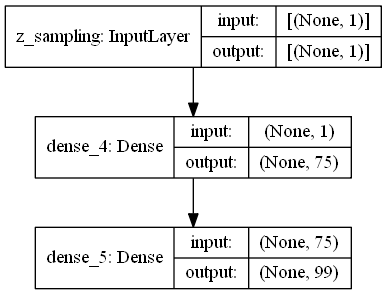

In [41]:
plot_model(decoder, show_shapes=True)

In [42]:
## Chain together to get VAE
i = encoder.inputs
if len(i) == 1:
 i = i[0]
 pass
z = encoder(i)[2]
o = decoder(z)

In [43]:
vae = Model(i, o, name='VAE')
vae.summary()

Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 99)]              0         
_________________________________________________________________
encoder (Functional)         [(None, 1), (None, 1), (N 7652      
_________________________________________________________________
decoder (Functional)         (None, 99)                7674      
Total params: 15,326
Trainable params: 15,326
Non-trainable params: 0
_________________________________________________________________


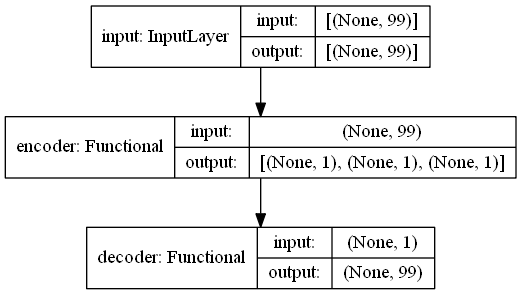

In [44]:
plot_model(vae, show_shapes=True)

In [45]:
def compile_vae (vae):

    # Get the latent p.d.f. mean and log-variance output layers from VAE encoder
    encoder   = vae.get_layer('encoder')
    z_log_var = encoder.get_layer('z_log_var').output
    z_mean    = encoder.get_layer('z_mean').output

    # Define reconstruction loss
    def reco_loss (y_true, y_pred):
        # Use binary cross-entropy loss
        reco_loss_value = binary_crossentropy(y_true, y_pred) # Averages over axis=-1
        #reco_loss_value = K.sum(reco_loss_value, axis=(1,2))
        reco_loss_value = K.sum(reco_loss_value)
        return reco_loss_value

    # Define Kullback-Leibler loss with reference to encoder output layers
    def kl_loss (y_true, y_pred):
        kl_loss_value = 0.5 * (K.square(z_mean) + K.exp(z_log_var) - 1. - z_log_var)
        kl_loss_value = K.sum(kl_loss_value, axis=-1)
        return kl_loss_value

    # Define VAE loss
    def vae_loss (y_true, y_pred):
        return reco_loss(y_true, y_pred) + kl_loss(y_true, y_pred)

    vae.compile(optimizer='adam', loss=vae_loss, metrics=[reco_loss, kl_loss])
    return

In [46]:
# Define parameters
nb_epochs  =  10
batch_size = 100

In [47]:
# Compile with given compile function to include custom VAE loss function
compile_vae(vae)

vae_history = vae.fit(X_train, X_train,
                      epochs=nb_epochs,
                      batch_size=batch_size,
                      shuffle=True,
                      validation_split=0.2)

Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 1s 98us/sample - loss: 51.8090 - reco_loss: 50.1790 - kl_loss: 1.6300 - val_loss: 33.0020 - val_reco_loss: 29.6650 - val_kl_loss: 3.3370
Epoch 2/10
8000/8000 [==============================] - 0s 48us/sample - loss: 26.9260 - reco_loss: 25.2532 - kl_loss: 1.6728 - val_loss: 22.3051 - val_reco_loss: 21.6429 - val_kl_loss: 0.6622
Epoch 3/10
8000/8000 [==============================] - 0s 40us/sample - loss: 20.1366 - reco_loss: 19.8249 - kl_loss: 0.3117 - val_loss: 18.4574 - val_reco_loss: 18.3684 - val_kl_loss: 0.0890
Epoch 4/10
8000/8000 [==============================] - 0s 44us/sample - loss: 18.0588 - reco_loss: 18.0187 - kl_loss: 0.0401 - val_loss: 17.6423 - val_reco_loss: 17.6123 - val_kl_loss: 0.0301
Epoch 5/10
8000/8000 [==============================] - 0s 47us/sample - loss: 17.6526 - reco_loss: 17.6060 - kl_loss: 0.0466 - val_loss: 17.5111 - val_reco_loss: 17.4529 - val_kl_

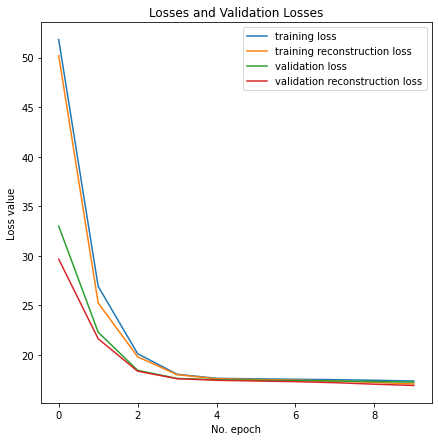

In [48]:
# Plot the two loss components and the total for both training and validation by epoch
plt.figure(figsize=(7, 7))
plt.plot(vae_history.history['loss'], label='training loss')
plt.plot(vae_history.history['reco_loss'], label='training reconstruction loss')
#plt.plot(vae_history.history['kl_loss'], label='training kl loss')
plt.plot(vae_history.history['val_loss'], label='validation loss')
plt.plot(vae_history.history['val_reco_loss'], label='validation reconstruction loss')
#plt.plot(vae_history.history['val_kl_loss'], label='validation kl loss')
plt.title('Losses and Validation Losses')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

In [49]:
z_mean, _, _ = encoder.predict(X_test)

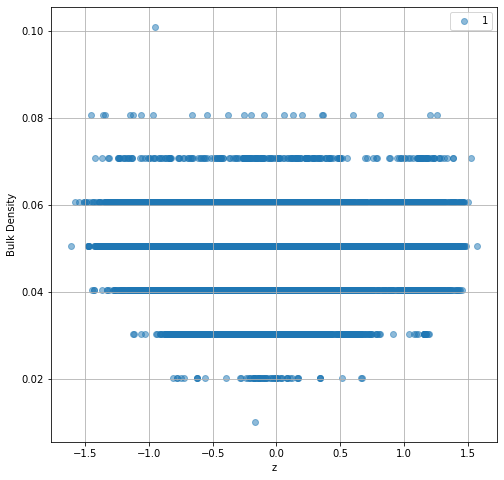

In [50]:
fig, ax = plt.subplots(1,1,figsize=(8,8))

for t in range(1, file_index):
    # Boolean mask
    mask = y_test == t
    # Scatter plot for current point on same axes as the rest
    single_label = z_mean[mask]
    ax.scatter(single_label[:, 0],
               np.mean(X_test[mask], axis=1),
               label=t, alpha=0.5)
    pass

# Draw legend
ax.legend()
# Include grid lines to make chosen region of latent space clear
ax.grid()
ax.set_xlabel('z')
ax.set_ylabel('Bulk Density')

plt.show()

In [51]:
part_size = 9

X_test_currents = []
for i in range(len(X_test)):
    jumps_possible = 0
    occs = np.array(X_test.iloc[i])
    for j in range(len(occs)): 
        if  j == len(occs)-1 and occs[j] == 1:
            jumps_possible += 1
        elif occs[j] == 1 and occs[j+1] == 0:
            jumps_possible += 1
    X_test_currents.append(jumps_possible / len(occs))
    
X_test_currents = np.array(X_test_currents)

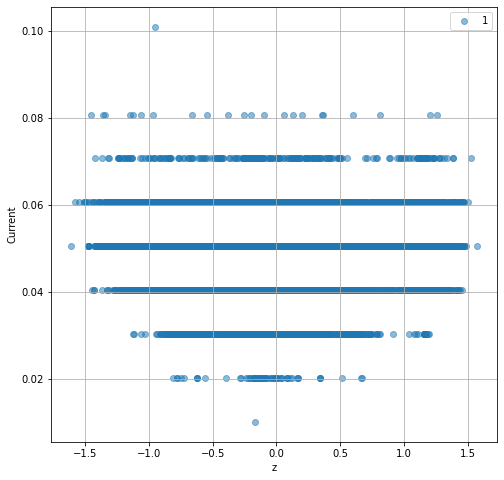

In [52]:
fig, ax = plt.subplots(1,1,figsize=(8,8))

for t in range(1, file_index):
    # Boolean mask
    mask = y_test == t
    # Scatter plot for current point on same axes as the rest
    single_label = z_mean[mask]
    ax.scatter(single_label[:, 0],
               X_test_currents[mask],
               label=t, alpha=0.5)
    pass

# Draw legend
ax.legend()
# Include grid lines to make chosen region of latent space clear
ax.grid()
ax.set_xlabel('z')
ax.set_ylabel('Current')

plt.show()

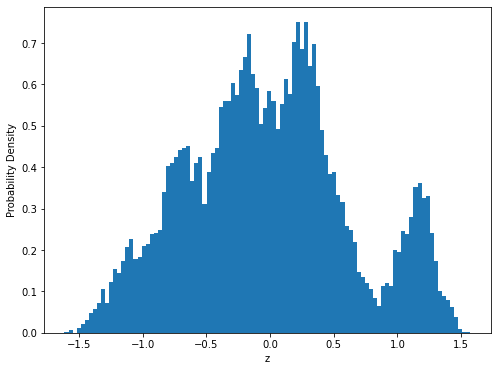

In [53]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
# Make histogram at the 
ax.hist(z_mean[:, 0],bins=100, density=True)

ax.set_xlabel('z')
ax.set_ylabel('Probability Density')

plt.show()

In [102]:
rates_list = []
filename = 'YLR012C_rates.DAT'
with open(filename) as tsv:
    for line in csv.reader(tsv, delimiter=' '):
        rates_list.append(float(line[-1]))
    
low_rates = np.array(rates_list) < 2

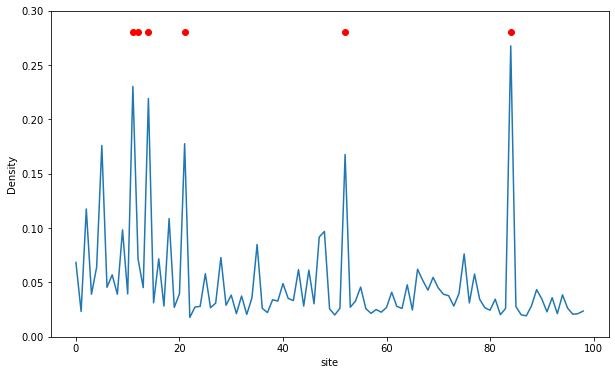

In [104]:
zs = np.array([-0.5])
nb_show = 1
fig, ax = plt.subplots(1,1,figsize=(10,6))
for i in range(nb_show):
    ax.plot(list(range(99)), decoder.predict(np.array([zs[i]]))[0])
    ax.scatter(list(range(99)), low_rates*0.29 - 0.01, color='r')
    ax.set_ylim(0, 0.3)
    ax.set_xlabel('site')
    ax.set_ylabel('Density')
plt.show()